In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import gumbi as gmb

%config InlineBackend.figure_format = 'retina'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Reproducible randomness

In [2]:
# ss = np.random.SeedSequence()
# hex(ss.entropy)

entropy = 0x6FC3469A06C95A424BBB9CD0702832C0
base_seed = np.random.SeedSequence(entropy)
SEEDs = base_seed.spawn(2)



## Student-T Process

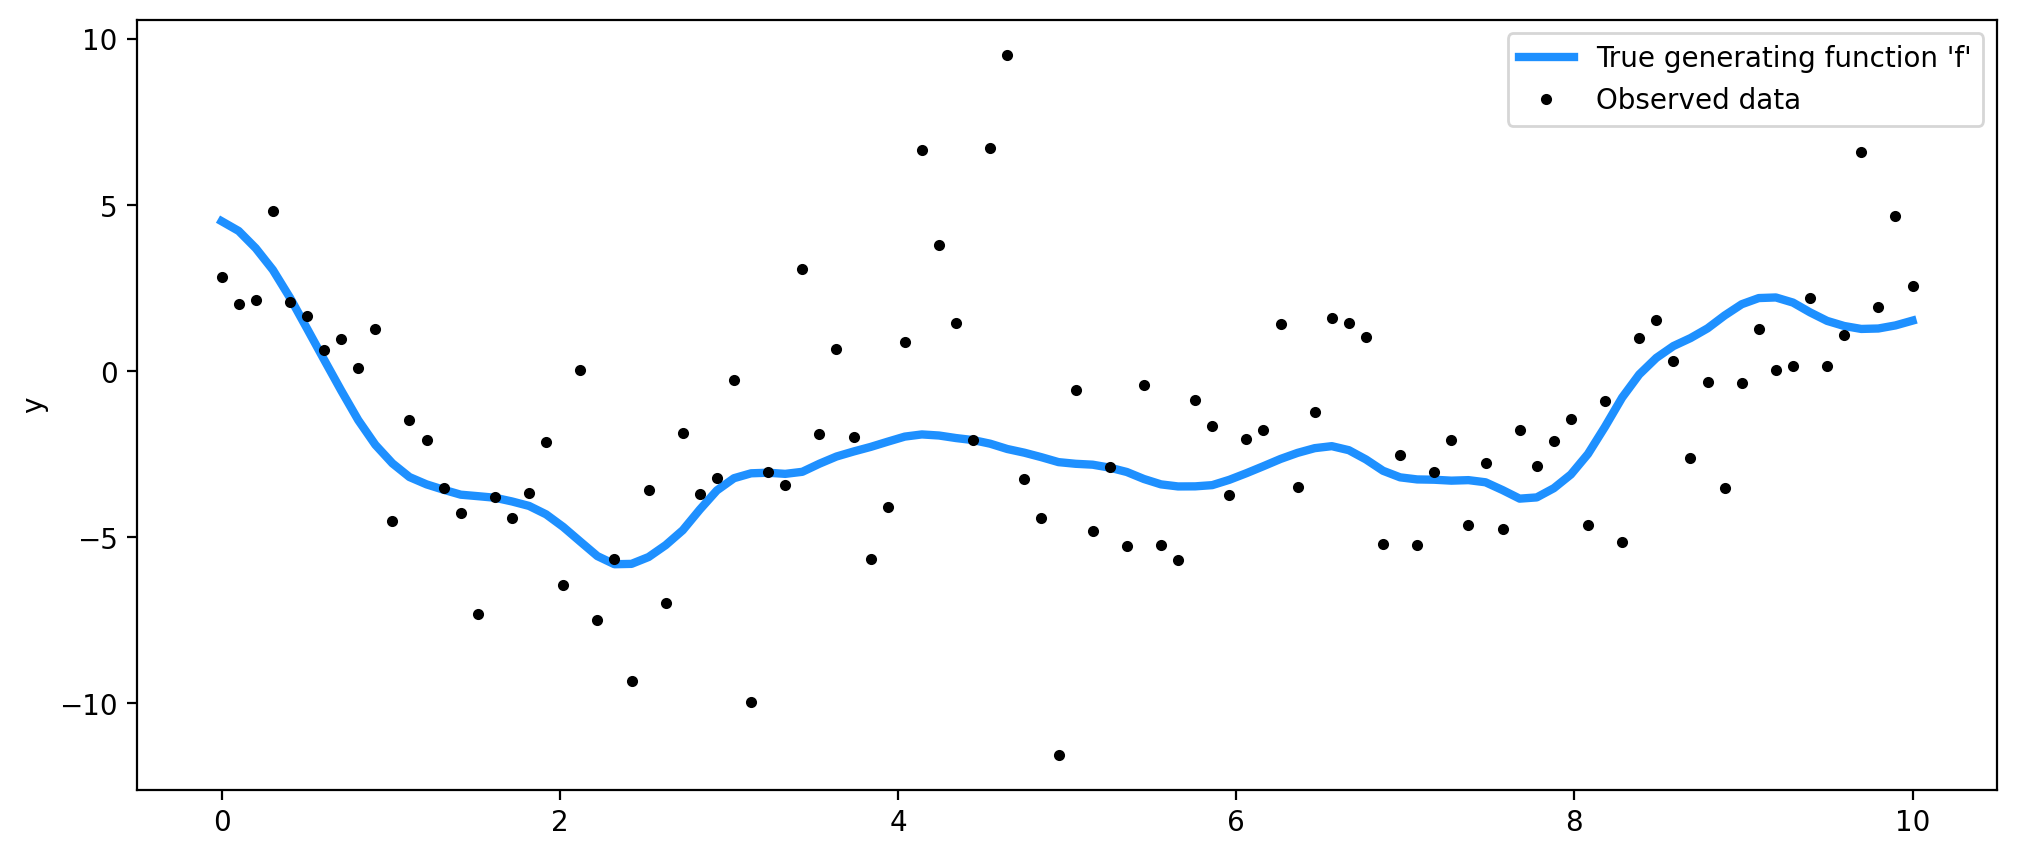

In [3]:
rng = np.random.default_rng(SEEDs[0])

n = 100  # The number of data points
X = np.linspace(0, 10, n)[
    :, None
]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because Pymc built on top of Theano
f_true = rng.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * rng.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
plt.legend()

ax.set_ylabel("y")
plt.legend()



In [4]:
data = np.column_stack([X, y])
df = pd.DataFrame(data, columns=["X", "y"])
ds = gmb.DataSet(df, outputs=["y"])
ds



DataSet:
	wide: [100 rows x 2 columns]
	tidy: [100 rows x 3 columns]
	outputs: ['y']
	inputs: ['X']

In [5]:
gp = gmb.GP(ds)

gp.specify_model(continuous_dims=["X"])
gp.build_model(continuous_kernel="Matern52")
mp = gp.find_MAP()



In [6]:
gp.prepare_grid()
pts = gp.grid_points.z[:, None].values()

# with gp.model:
# #     X_new = pm.Data('X_new', pts)
#     pred = gp.gp_dict['total'].conditional('latent_posterior', pts)

with gp.model:
    pred_samples = pm.sample_posterior_predictive(
        [mp], var_names=["latent_posterior", "ml"], samples=200
    )


TypeError: sample_posterior_predictive() got an unexpected keyword argument 'samples'

<AxesSubplot:>

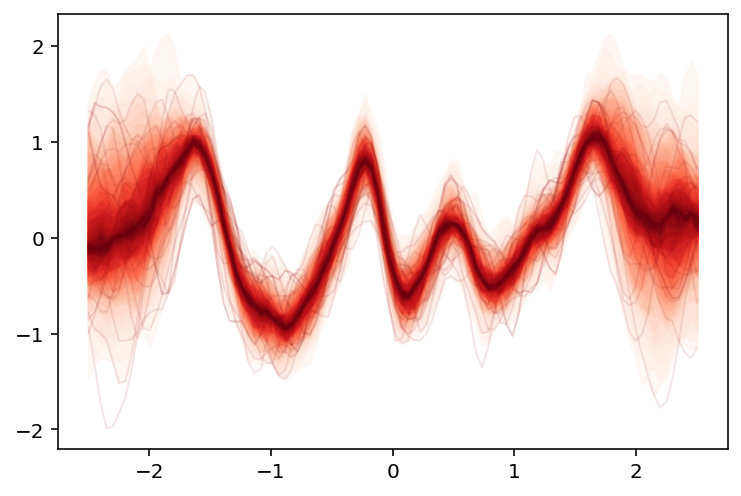

In [ ]:
plot_gp_dist(plt.gca(), pred_samples["latent_posterior"], pts)



In [34]:
gp = gmb.GP(ds)

gp.specify_model(continuous_dims=["X"])
gp.build_latent(continuous_kernel="Matern52")

with gp.model:
    f = gp.prior
    _, obs_y = gp.get_shaped_data()

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=obs_y)

    trace = pm.sample(
        1000, chains=2, cores=1, return_inferencedata=True, random_seed=2022
    )



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, latent_prior_rotated_, η_total, ℓ_total]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 504 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
az.summary(trace, var_names=["σ", "ν", "η_total", "ℓ_total"])





,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,0.459,0.112,0.249,0.657,0.003,0.002,1524.0,1437.0,1.00
ν,11.056,8.672,2.162,27.448,0.221,0.157,1641.0,1600.0,1.00
η_total,0.974,0.318,0.460,1.603,0.022,0.017,264.0,158.0,1.00
ℓ_total,0.426,0.162,0.136,0.693,0.008,0.006,403.0,541.0,1.01


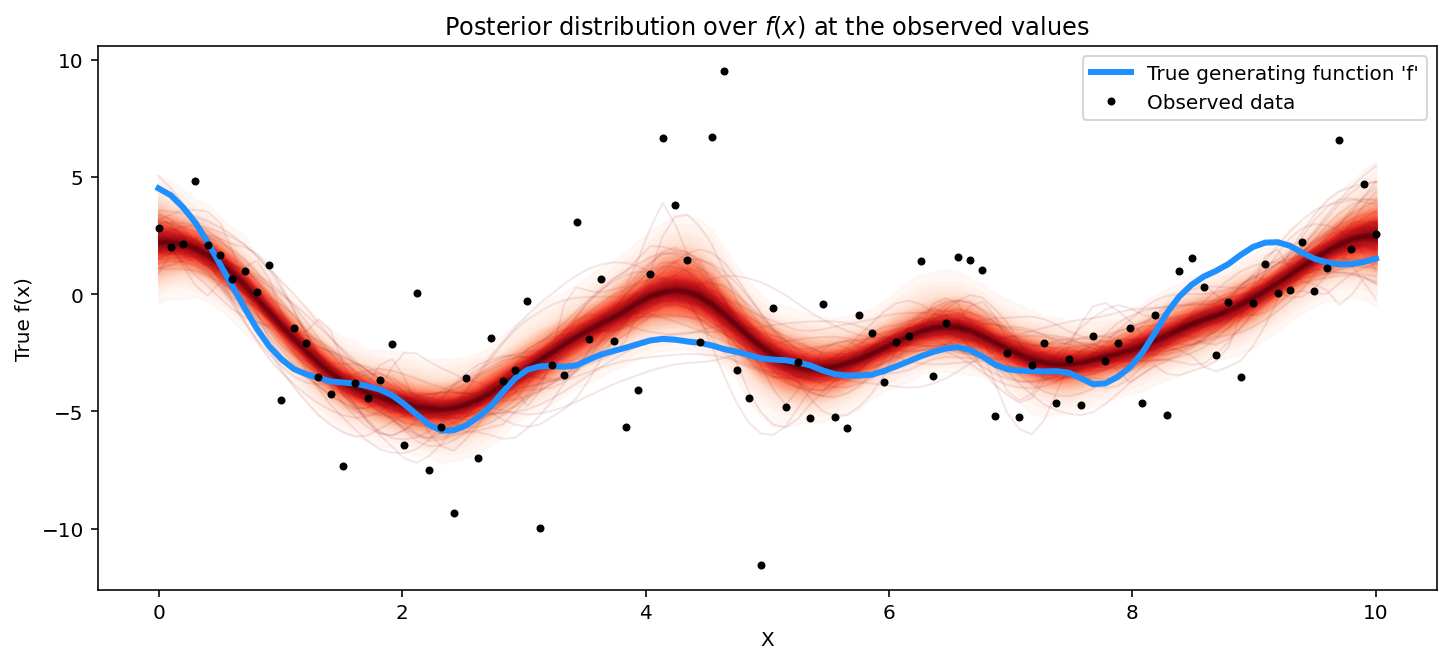

In [36]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

predictions = gp.parray(y=trace.posterior["latent_prior"][0, :, :], stdzd=True)

plot_gp_dist(ax, predictions.values(), X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend()




## Classification

In [19]:
import sys

# reset the random seed for the new example
rng = np.random.default_rng(SEEDs[1])

# number of data points
n = 100

# x locations
X = np.linspace(0, 1.5, n)

# true covariance
ℓ_true = 0.1
η_true = 2.0
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(1, ℓ_true)
K = cov_func(X[:, None]).eval()

# zero mean function
mean = np.zeros(n)

# sample from the gp prior
f_true = rng.multivariate_normal(mean, K + 1e-6 * np.eye(n), 1).flatten()

# link function
def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps


y = rng.binomial(1, p=invlogit(f_true))


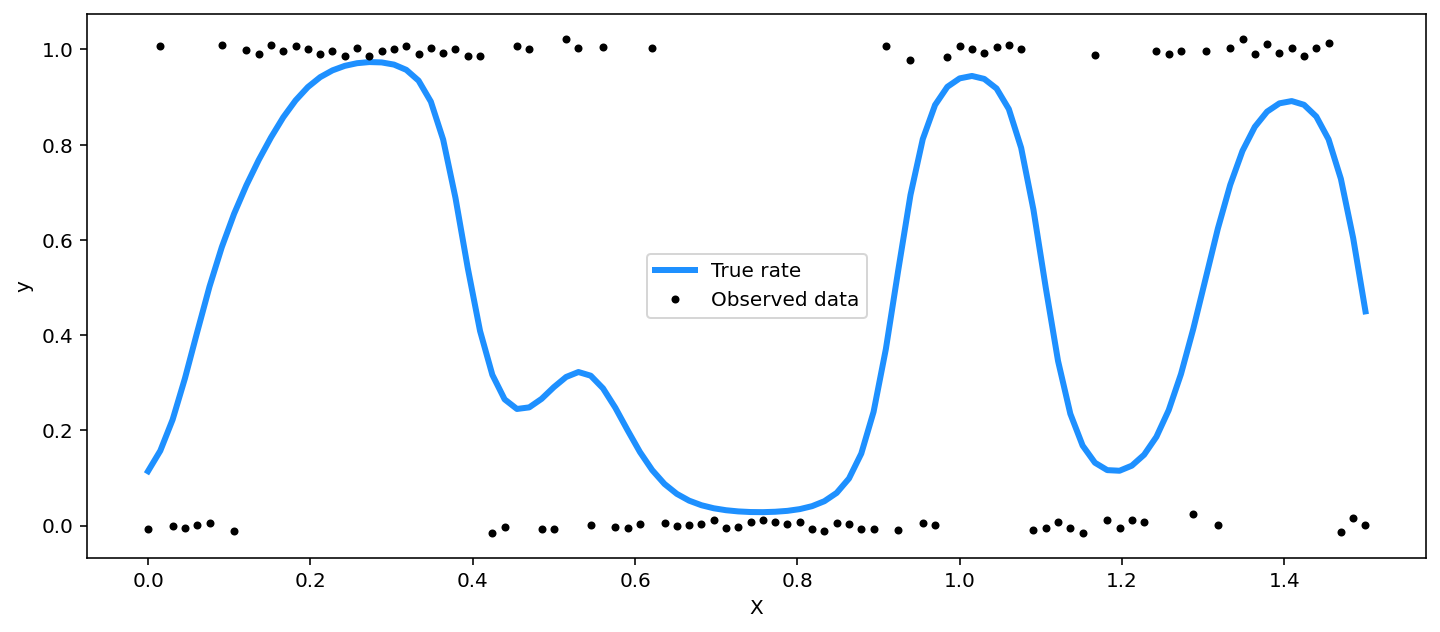

In [4]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

ax.plot(X, invlogit(f_true), "dodgerblue", lw=3, label="True rate")
# add some noise to y to make the points in the plot more visible
ax.plot(X, y + rng.normal(size=n) * 0.01, "ko", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend()





In [5]:
data = np.column_stack([X, y])
df = pd.DataFrame(data, columns=["X", "y"])
ds = gmb.DataSet(df, outputs=["y"], logit_vars=["p"])
del ds.stdzr["y"]  # Don't standardize the binary outcome
ds



DataSet:
	wide: [100 rows x 2 columns]
	tidy: [100 rows x 3 columns]
	outputs: ['y']
	inputs: ['X']

In [6]:
gp = gmb.GPC(ds)

gp.specify_model(continuous_dims=["X"])
gp.build_model()
gp.sample(1000, chains=2, cores=1, random_seed=2022)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [latent_prior_rotated_, η_total, ℓ_total]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 222 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [7]:
gp.prepare_grid()
gp.draw_grid_samples()



('posterior_samples',): [[(0.55469215,) (0.50382259,) (0.45640388,) ... (0.81062671,)
  (0.81870234,) (0.82129104,)]
 [(0.48852792,) (0.48801392,) (0.49322148,) ... (0.2614539 ,)
  (0.25195545,) (0.23634298,)]
 [(0.03527021,) (0.02398699,) (0.01611803,) ... (0.56565647,)
  (0.63767145,) (0.7088195 ,)]
 ...
 [(0.3975044 ,) (0.34827322,) (0.29641576,) ... (0.29205791,)
  (0.36137722,) (0.43184387,)]
 [(0.33563255,) (0.31801058,) (0.28976002,) ... (0.74681145,)
  (0.7499288 ,) (0.74244176,)]
 [(0.54958189,) (0.49061389,) (0.45775745,) ... (0.0646207 ,)
  (0.087374  ,) (0.12244907,)]]

<AxesSubplot:>

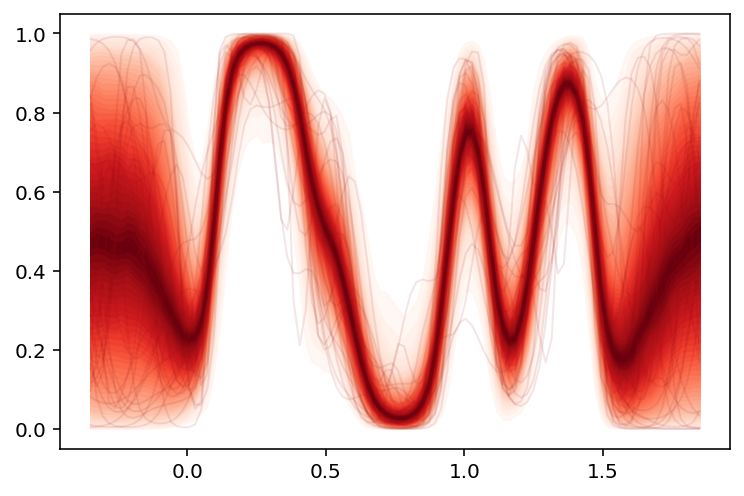

In [10]:
# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

plot_gp_dist(plt.gca(), gp.predictions.values(), gp.predictions_X.values())



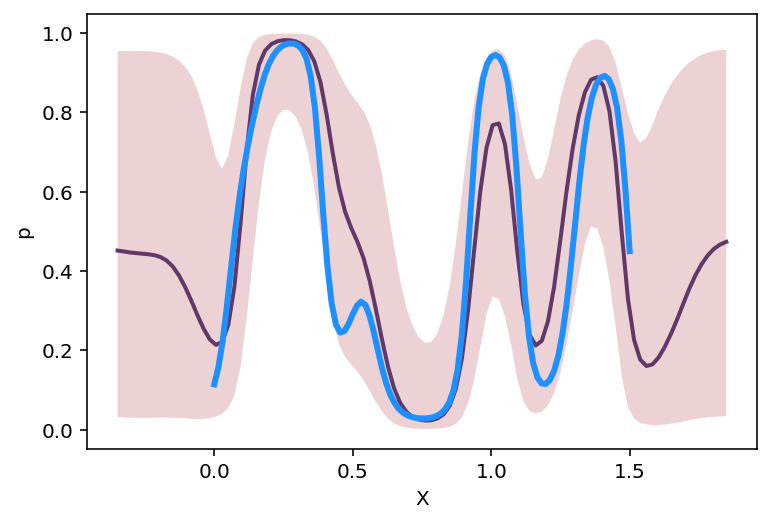

In [20]:
p_X = gp.predictions_X
p = gp.uparray(
    "p",
    μ=gp.predictions.t.values().mean(0),
    σ2=gp.predictions.t.values().std(0),
    stdzd=True,
)
    "p",
    μ=gp.predictions.t.values().mean(0),
    σ2=gp.predictions.t.values().std(0),
    stdzd=True,

)
pp = gmb.ParrayPlotter(p_X, p)
pp.plot()

plt.plot(X, invlogit(f_true), "dodgerblue", lw=3, label="True generating function 'f'")


In [32]:
gp = gmb.GP(ds)

gp.specify_model(continuous_dims=["X"])
gp.build_latent(eps=1e-6)

with gp.model:
    f = gp.prior
    _, obs_y = gp.get_shaped_data()

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=obs_y)

    trace = pm.sample(
        1000, chains=2, cores=1, return_inferencedata=True, random_seed=2022
    )
#     mp = pm.find_MAP()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [latent_prior_rotated_, η_total, ℓ_total]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


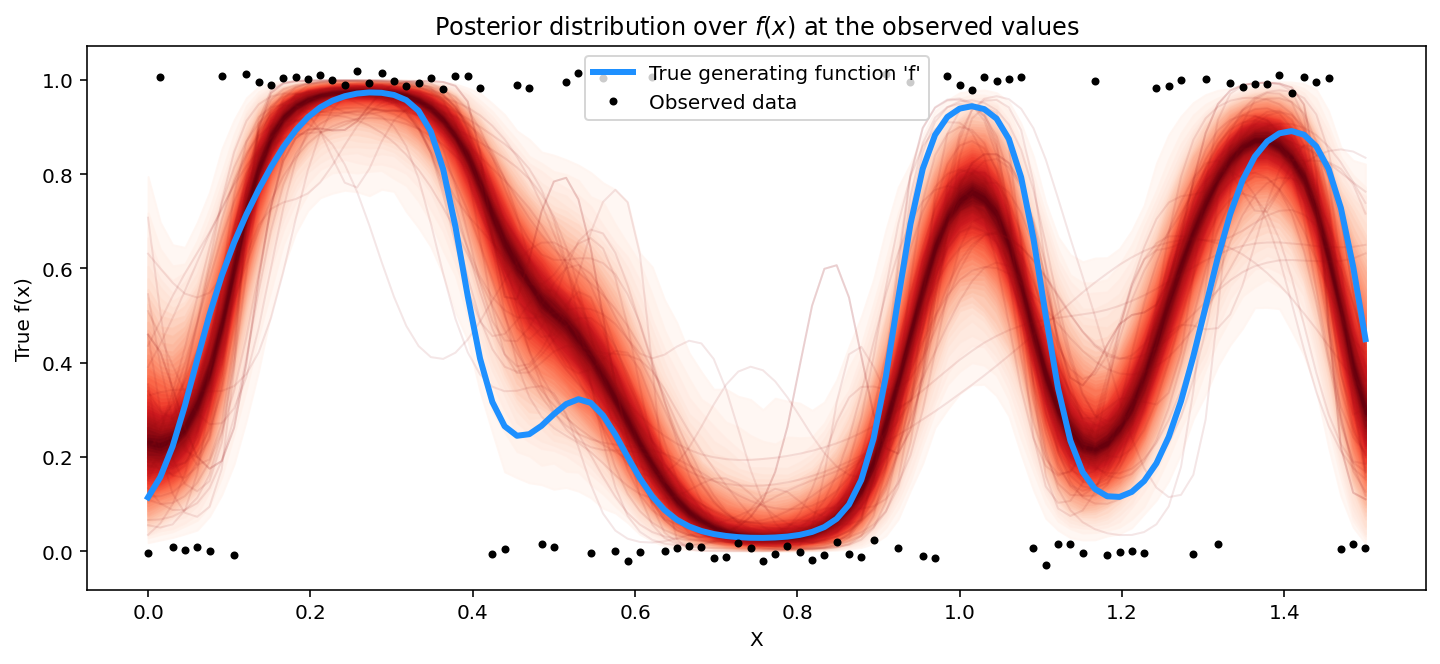

In [7]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

p_pred = gp.parray(p=trace.posterior["p"][0, :, :])

plot_gp_dist(ax, p_pred.values(), X)

# plot the data and the true latent function
ax.plot(X, invlogit(f_true), "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y + rng.normal(size=n) * 0.01, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend()

